In [1]:
import pickle
import gzip
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

from tensorflow import set_random_seed
set_random_seed(125)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
import keras

from keras.layers import Conv2D,MaxPooling2D,Flatten
from sklearn.externals import joblib



Using TensorFlow backend.


In [2]:
def accuracy(test_data,test_target,model):
    correct = 0
    predicted = model.predict(test_data,verbose=True)
    left = np.array(np.argmax(predicted,axis=1)).flatten()
    right = np.argmax(test_target,axis=1)
    confusion_mat = np.zeros((10,10))
    for i in range(len(test_target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[right[i]][left[i]] =confusion_mat[right[i]][left[i]] +1
    return correct/len(test_target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

In [3]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()
train_data = np.append(training_data[0],validation_data[0],axis=0)
train_target = np.append(training_data[1],validation_data[1],axis=0)
train_target = keras.utils.to_categorical(train_target, 10)
test_target = keras.utils.to_categorical(test_data[1], 10)
test_data = test_data[0]

In [4]:
image_vector_size = 28* 28
train_data = train_data.reshape(train_data.shape[0], image_vector_size)
test_data = test_data.reshape(test_data.shape[0], image_vector_size)
num_classes =10

In [5]:
NNType = 'CNN'

if(NNType=='CNN'):
    print("Processing for CNN")
    filename = '../mnist.pkl.gz'
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    num_classes = 10

    x_train = np.append(training_data[0],validation_data[0],axis=0)
    y_train = np.append(training_data[1],validation_data[1])
    x_test = test_data[0]
    y_test = test_data[1]

    img_x, img_y = 28, 28
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
    x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
    input_shape = (img_x, img_y, 1)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

Processing for CNN


In [25]:
def baseline():
    model = Sequential()
    model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

def highHidden():
    drop_out = 0.1
    model = Sequential()
    model.add(Dense(units=32,activation='sigmoid',input_shape=(image_vector_size,)))
    model.add(Activation('tanh'))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(128, input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def lowHidden():
    model = Sequential()
    model.add(Dense(units=1024,activation='tanh',input_shape=(image_vector_size,)))
    model.add(Dense(2048,activation='relu',input_dim=image_vector_size))
    model.add(Dense(units=num_classes, activation='softmax'))

    #sgd = optimizers.SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])    
    model.summary()
    return model

def conv():
    model = Sequential()
    model.add(Conv2D(512, kernel_size=(15, 15), strides=(1, 1),activation='tanh',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(10, 10), strides=(5, 5)))
    model.add(Flatten())
    model.add(Dense(1024, activation='tanh'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [26]:
model = conv()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 512)       115712    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                20490     
Total params: 2,760,714
Trainable params: 2,760,714
Non-trainable params: 0
_________________________________________________________________


In [27]:
if(NNType=='CNN'):
    print("Processing for CNN")
    filename = '../mnist.pkl.gz'
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    num_classes = 10

    x_train = np.append(training_data[0],validation_data[0],axis=0)
    y_train = np.append(training_data[1],validation_data[1])
    x_test = test_data[0]
    y_test = test_data[1]

    img_x, img_y = 28, 28
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
    x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
    input_shape = (img_x, img_y, 1)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=5, mode='auto')
    history = model.fit(x_train, y_train, 
                        batch_size=64,
                        epochs=150,
                        verbose=True,
                        validation_split=.1,
                        callbacks = [earlystopping_cb])

Processing for CNN
Train on 54000 samples, validate on 6000 samples
Epoch 1/150
54000/54000 [==============================] - 68s 1ms/step - loss: 0.4492 - acc: 0.8488 - val_loss: 0.1090 - val_acc: 0.9705
Epoch 2/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.1169 - acc: 0.9626 - val_loss: 0.0859 - val_acc: 0.9722
Epoch 3/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.0894 - acc: 0.9718 - val_loss: 0.0680 - val_acc: 0.9795
Epoch 4/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.0725 - acc: 0.9768 - val_loss: 0.0578 - val_acc: 0.9835
Epoch 5/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.0667 - acc: 0.9790 - val_loss: 0.0713 - val_acc: 0.9800
Epoch 6/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.0570 - acc: 0.9817 - val_loss: 0.0640 - val_acc: 0.9815
Epoch 7/150
54000/54000 [==============================] - 67s 1ms/step - loss: 0.0570 - acc: 0.9824 - v

In [9]:
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, 
                                 patience=5, mode='auto')

history = model.fit(train_data, train_target, 
                    batch_size=512, 
                    epochs=150,
                    verbose=True,
                    validation_split=.1,
                   callbacks = [earlystopping_cb])

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (60000, 784)

In [28]:
if(NNType=='CNN'):
    loss,acc = model.evaluate(x_train, y_train, verbose=True)
    print("The Loss for Training is: "+str(loss))
    print("The Accuracy for Training is: "+str(acc))
else:
    loss,acc = model.evaluate(train_data, train_target, verbose=True)
    print("The Loss for Training is: "+str(loss))
    print("The Accuracy for Training is: "+str(acc))

60000/60000 [==============================] - 29s 478us/step
The Loss for Training is: 0.024853544017367193
The Accuracy for Training is: 0.9918166666666667


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f93f054d2b0>,
      dtype=object)

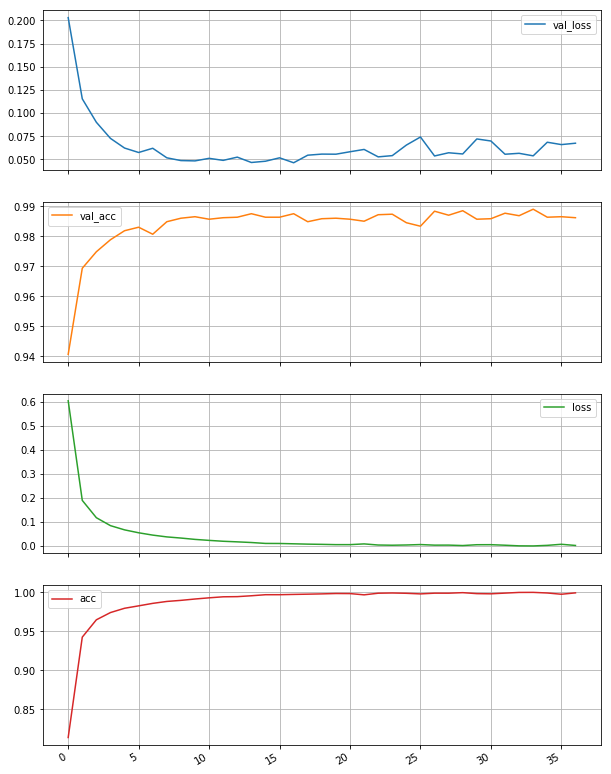

In [10]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [53]:
#joblib.dump(model,'./models/DNN_lowHidden.joblib',compress=True)
model = joblib.load('./models/DNN_lowHidden.joblib')

# Pre Process USPS

In [14]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [15]:
if(NNType =='CNN'):
    print("Processing for CNN")
    USPSMat  = []
    USPSTar  = []
    curPath  = '../USPSdata/Numerals'
    savedImg = []

    for j in range(0,10):
        curFolderPath = curPath + '/' + str(j)
        imgs =  os.listdir(curFolderPath)
        for img in imgs:
            curImg = curFolderPath + '/' + img
            if curImg[-3:] == 'png':
                img = Image.open(curImg,'r')
                img = img.resize((28, 28))
                img = np.asarray(img)
                #savedImg = img
                #imgdata = (255-np.array(img.getdata()))/255
                USPSMat.append(img)
                USPSTar.append(j)
    USPSMat = np.asarray(USPSMat)
    USPSMat = USPSMat.reshape(USPSMat.shape[0], 28, 28, 1)

Processing for CNN


In [16]:
USPSTar = keras.utils.to_categorical(USPSTar, num_classes)

In [29]:
if(NNType =='CNN'):
    acc,conf_mat = accuracy(x_test,y_test,model)
    print("The Accuracy for Testing on MNIST is: "+str(acc))
    print("The Confusion Matrix is: ")
    print(conf_mat)
    _,precision,recall = more_metrics(pd.DataFrame(conf_mat))
    print("The Precision & Recall is: ")
    df = pd.DataFrame(np.multiply(precision,100))
    df.columns = ["Recall"]
    df1 = pd.DataFrame(np.multiply(recall,100))
    df1.columns = ["Precision"]
    print(pd.concat([df,df1],axis=1))
else:
    acc,conf_mat = accuracy(test_data,test_target,model)
    print("The Accuracy for Testing on MNIST is: "+str(acc))
    print("The Confusion Matrix is: ")
    print(conf_mat)
    _,precision,recall = more_metrics(pd.DataFrame(conf_mat))
    print("The Precision & Recall is: ")
    df = pd.DataFrame(np.multiply(precision,100))
    df.columns = ["Recall"]
    df1 = pd.DataFrame(np.multiply(recall,100))
    df1.columns = ["Precision"]
    print(pd.concat([df,df1],axis=1))

10000/10000 [==============================] - 5s 475us/step
The Accuracy for Testing on MNIST is: 0.9844
The Confusion Matrix is: 
     0     1     2     3    4    5    6     7    8    9
0  972     0     0     0    0    2    1     3    2    0
1    0  1124     0     1    3    1    4     0    2    0
2    2     2  1010     6    2    0    3     6    1    0
3    0     0     1  1004    0    4    0     0    1    0
4    0     0     0     0  976    1    3     0    1    1
5    0     0     0     3    0  887    1     1    0    0
6    5     2     0     0    1   11  939     0    0    0
7    0     5     4     6    0    2    0  1007    2    2
8    0     0     1     2    0    8    0     1  962    0
9    2     0     0     6   10   18    1     3    6  963
The Precision & Recall is: 
      Recall  Precision
0  99.183673  99.082569
1  99.030837  99.205649
2  97.868217  99.409449
3  99.405941  97.665370
4  99.389002  98.387097
5  99.439462  94.967880
6  98.016701  98.634454
7  97.957198  98.628795
8  98.76

In [30]:
acc,conf_mat = accuracy([USPSMat],USPSTar,model)
print("The Accuracy for Testing on USPS is: "+str(acc))
print("The Confusion Matrix is: ")
print(conf_mat)
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Recall"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Precision"]
print(pd.concat([df,df1],axis=1))

19999/19999 [==============================] - 9s 471us/step
The Accuracy for Testing on USPS is: 0.06975348767438372
The Confusion Matrix is: 
      0  1  2  3  4    5     6  7   8  9
0   287  0  0  1  4  301  1384  0  23  0
1  1665  0  0  0  1   35   281  0  18  0
2   836  0  0  0  1   25  1131  0   6  0
3   305  0  0  0  0   79  1611  0   5  0
4   397  0  0  0  1  567  1023  0  12  0
5   224  0  0  0  1  312  1429  0  34  0
6   992  0  0  0  3  232   744  0  29  0
7  1229  2  0  0  1    9   757  0   2  0
8   301  0  0  1  2  289  1356  0  51  0
9   361  0  0  0  0  277  1348  0  14  0
The Precision & Recall is: 
   Recall  Precision
0   14.35   4.350462
1    0.00   0.000000
2    0.00        NaN
3    0.00   0.000000
4    0.05   7.142857
5   15.60  14.675447
6   37.20   6.724512
7    0.00        NaN
8    2.55  26.288660
9    0.00        NaN


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
16.8